Визуализация данных для датасета страховки. Датасет взят отсюда:
https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset

In [239]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
first_df = pd.read_csv('insurance2.csv')
second_df = pd.read_csv('insurance3r2.csv')
first_df.shape, second_df.shape

((1338, 8), (1338, 9))

In [240]:
set(second_df.columns) - set(first_df.columns)

{'steps'}

В датасете second есть лишний столбец признаков, избавимся от него.

In [241]:
second_df = second_df.drop(columns='steps')

Проверим датасеты на наличие NaN.

In [242]:
first_df.isna().sum(), second_df.isna().sum()

(age               0
 sex               0
 bmi               0
 children          0
 smoker            0
 region            0
 charges           0
 insuranceclaim    0
 dtype: int64, age               0
 sex               0
 bmi               0
 children          0
 smoker            0
 region            0
 charges           0
 insuranceclaim    0
 dtype: int64)

Пропущенных данных нет, заполнение датасета не требуется.
Построим базовый случай, относительно которого будет сравнивать наши улучшения модели.

In [243]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(first_df.drop(columns='insuranceclaim'), 
                                                    first_df['insuranceclaim'], 
                                                    random_state=17, 
                                                    test_size=0.3)

logreg = LogisticRegression().fit(X_train, y_train)
base_logreg = logreg.score(X_test, y_test)

linear = SGDClassifier().fit(X_train, y_train)
base_linear = linear.score(X_test, y_test)
base_logreg, base_linear

(0.7761194029850746, 0.43283582089552236)

Давайте взглянем на общую картину, используя методы seaborn pairplot и heatmap. Pairplot строит попарно зависимости любых двух признаков и строит график распределения каждого признака. Хорошим признаком будет являтся то, что на графиках группы маркеров и графики распределения будут разделены. С помощью heatmap постриом тепловую карту коэффициентов корреляции. Если коэффицент корреляции будет близок к 1, то пара признаков линейно зависимы, и один из них можно выбросить.

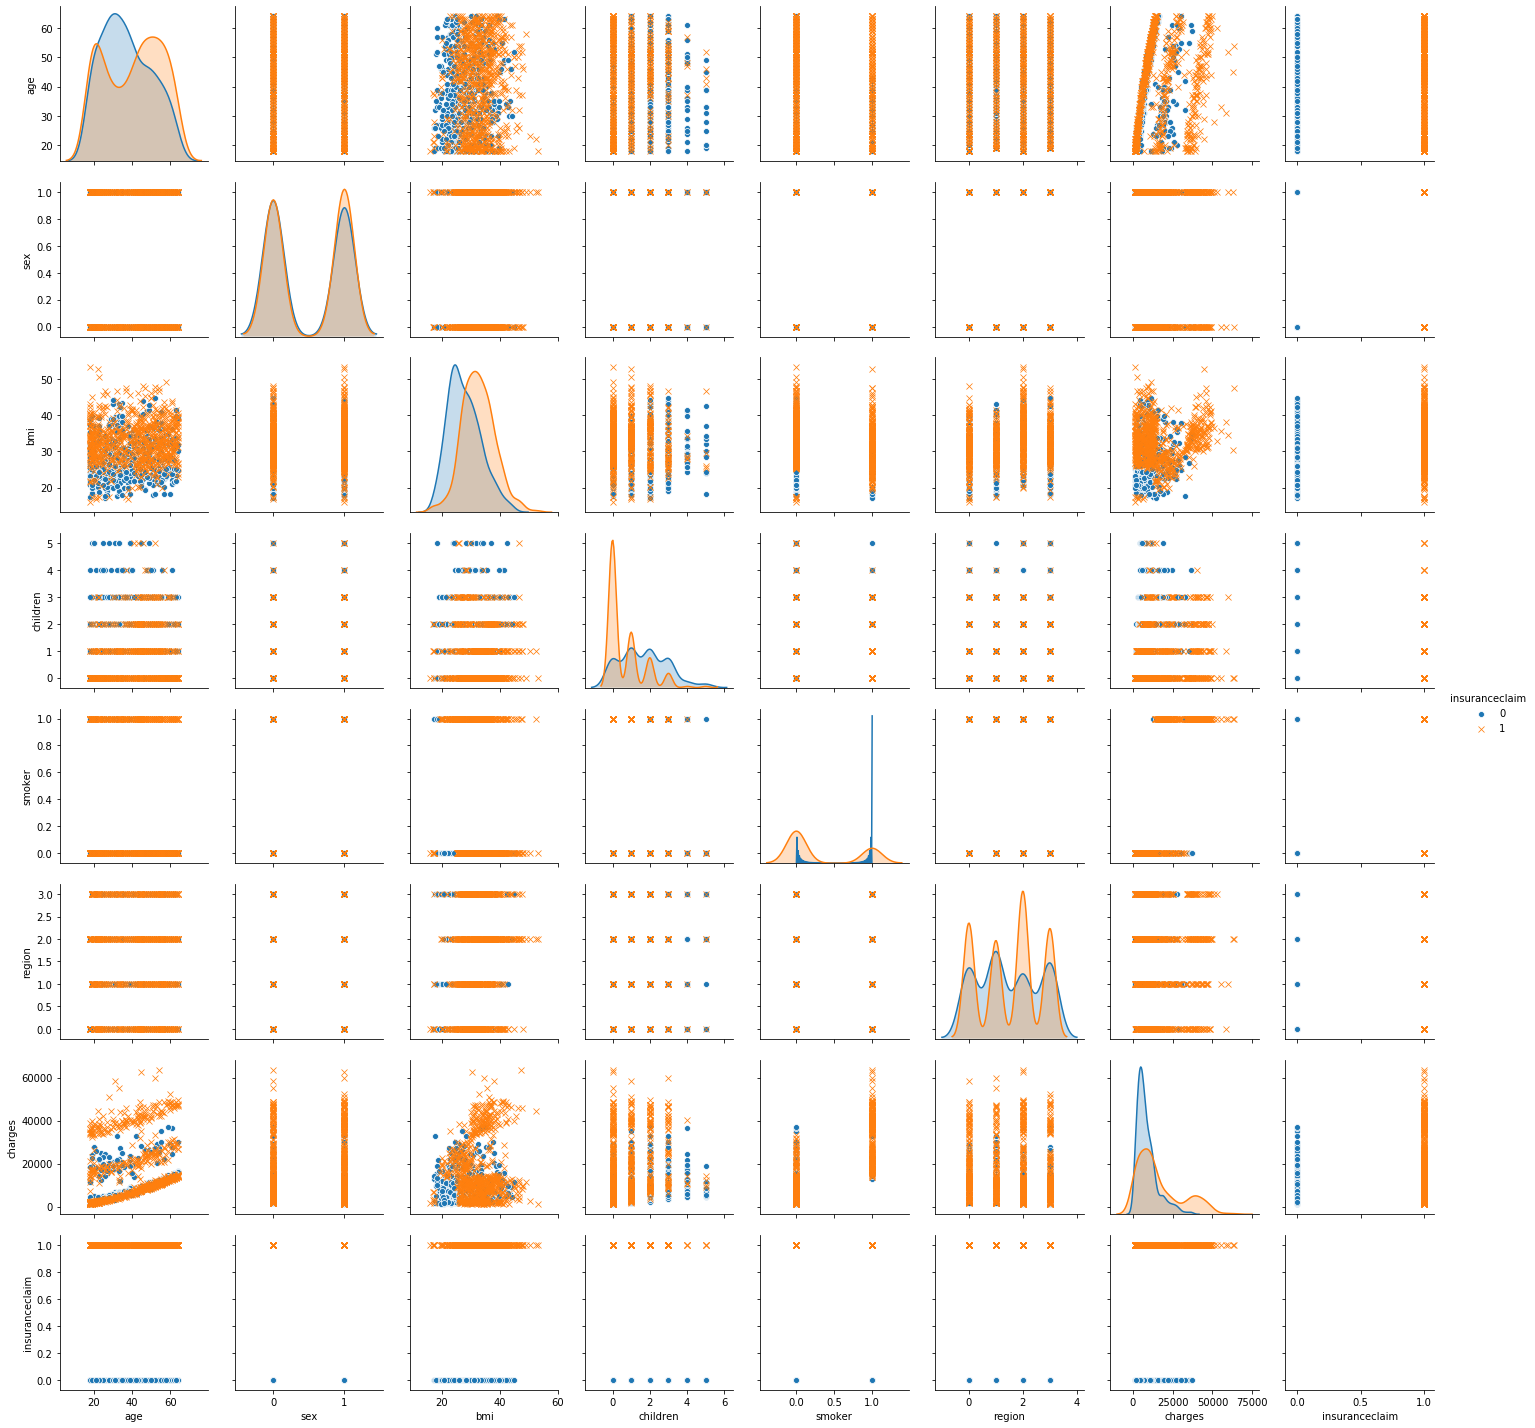

In [244]:
g = sns.pairplot(first_df, hue="insuranceclaim", markers = ['o', 'x'])

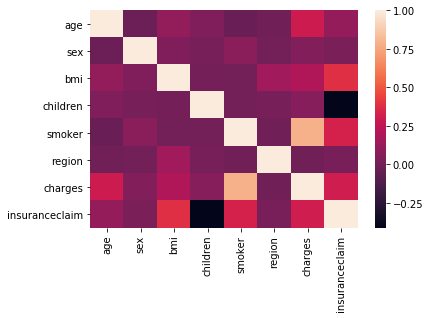

In [245]:
f = sns.heatmap(first_df.corr())

Явной границы разделения на pairplot и лишних признаков на heatmap не обнаружено. Попробуем отмасштабировать данные и применить методы PCA и t-SNE.

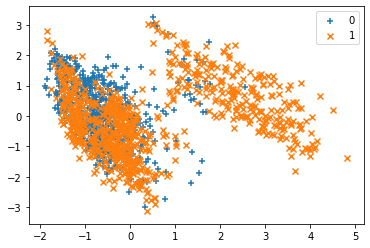

In [246]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = first_df.drop(columns='insuranceclaim')
y = first_df['insuranceclaim']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(2)
X_pca = pca.fit_transform(X_scaled)

# разделим X на два массива, по меткам y==0 и y==1 соотвественно
X_0 = np.array([a for (a,b) in zip(X_pca, y) if b==0 ])
X_1 = np.array([a for (a,b) in zip(X_pca, y) if b==1 ])

import matplotlib.pyplot as plt
plt.scatter(X_0[:,0], X_0[:,1], label='0', marker='+')
plt.scatter(X_1[:,0], X_1[:,1], label='1', marker='x')
plt.legend()

Применение PCA не дало качественного разделения на категории.

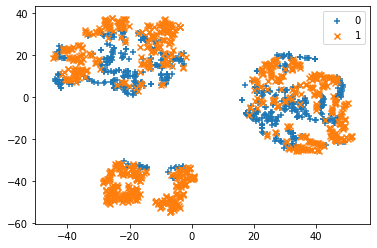

In [247]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# разделим данные таким же образом
X_0 = np.array([a for (a,b) in zip(X_tsne, y) if b==0 ])
X_1 = np.array([a for (a,b) in zip(X_tsne, y) if b==1 ])

import matplotlib.pyplot as plt
plt.scatter(X_0[:,0], X_0[:,1], label='0', marker='+')
plt.scatter(X_1[:,0], X_1[:,1], label='1', marker='x')
plt.legend()

t-SNE также не дает визуально качественного разделения.
Приступим к формированию признаков и их оценке их влияния. 
Переведем категориальные данные в дамми-переменные.
Из описания задачи известно, что идаельный индекс массы тела bmi находится в диапазоне от 18.5 до 25. Используем это в своей модели.

In [248]:
sex_dumm = pd.get_dummies(first_df['sex']).rename({0:'female', 1:'male'}, 
                                                  axis=1)
region_dumm = pd.get_dummies(first_df['region'], prefix='region')
first_df_plus = first_df.drop(columns=['sex', 'region'])
first_df_plus['ideal_bmi'] = first_df['bmi'].apply(
                    lambda x: 1 if 18.5 <x< 25 else 0)
first_df_plus = pd.concat([first_df_plus, sex_dumm, region_dumm], axis=1)
first_df_plus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 13 columns):
age               1338 non-null int64
bmi               1338 non-null float64
children          1338 non-null int64
smoker            1338 non-null int64
charges           1338 non-null float64
insuranceclaim    1338 non-null int64
ideal_bmi         1338 non-null int64
female            1338 non-null uint8
male              1338 non-null uint8
region_0          1338 non-null uint8
region_1          1338 non-null uint8
region_2          1338 non-null uint8
region_3          1338 non-null uint8
dtypes: float64(2), int64(5), uint8(6)
memory usage: 81.1 KB


Введем нелинейные признаки для всех некатегориальных признаков с помощью функций log.

In [249]:
for feature in ('age', 'bmi', 'charges'):
    first_df_plus[feature+'_log'] = first_df_plus[feature].apply(np.log)
first_df_plus.columns

Index(['age', 'bmi', 'children', 'smoker', 'charges', 'insuranceclaim',
       'ideal_bmi', 'female', 'male', 'region_0', 'region_1', 'region_2',
       'region_3', 'age_log', 'bmi_log', 'charges_log'],
      dtype='object')

Отмасштабируем данные

In [250]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled_df = first_df_plus.drop(columns='insuranceclaim')
X_scaled = scaler.fit_transform(first_df_plus.drop(columns='insuranceclaim'))
X_scaled.shape

(1338, 15)

Сравним результат с базовым случаем

In [251]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled,
                                                                 y, random_state=17,
                                                                 test_size=0.3)

logreg = LogisticRegression().fit(X_train_scaled, y_train)
acc2_logreg = logreg.score(X_test_scaled, y_test)

linear = SGDClassifier().fit(X_train_scaled, y_train)
acc2_linear = linear.score(X_test_scaled, y_test)

acc2_logreg, acc2_linear

(0.8432835820895522, 0.8656716417910447)

Попробуем отбросить незначительные признаки, используя два метода, 
SelectPerctntile и с помощью оценки важности признака в RandomForest 

In [252]:
# отбор признаков с помощью оценки важности признаков через RandomForest
from sklearn.feature_selection import SelectPercentile
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_scaled, y)
features = first_df_plus.drop(columns='insuranceclaim').columns

importnances = {'imp': forest.feature_importances_, 'features':features}
importnances = pd.DataFrame(importnances)
importnances = importnances.sort_values('imp', ascending=False)
importnances['cumsum'] = np.cumsum(importnances['imp'])
importnances.index = range(importnances.shape[0])

# отбросим все признаки, которые влияют на результат не более чем 0.9 суммарно
list_to_drop_1 = [importnances.iloc[line][1] for line in range(importnances.shape[0]) if importnances.iloc[line][2] >= 0.9]
list_to_drop_1

['age_log',
 'smoker',
 'ideal_bmi',
 'region_2',
 'region_0',
 'male',
 'female',
 'region_1',
 'region_3']

In [253]:
# оценка важности признаков через SelectPercentile
select = SelectPercentile(percentile=50)
select.fit(X_scaled, y)
X_selected = select.transform(X_scaled)
list_to_drop_2 = [feature for feature, need_cond in zip(X_scaled_df.columns, select.get_support()) if not need_cond]
list_to_drop_2

['age',
 'female',
 'male',
 'region_0',
 'region_1',
 'region_2',
 'region_3',
 'age_log']

Два списка лишних признаков отличаются друг от друга лишь на одну позицию.
Очистим датасет от лишних признаков и проведем обучение модели.

In [268]:
X_cleaned = first_df_plus.drop(columns=['insuranceclaim', *list_to_drop_1])
X_cleaned = pd.DataFrame(scaler.fit_transform(X_cleaned.values),
                   columns=X_cleaned.columns)

X_train_cleaned, X_test_cleaned, y_train, y_test = train_test_split(X_cleaned,
                                                                 y, random_state=17,
                                                                 test_size=0.3)

logreg = LogisticRegression().fit(X_train_cleaned, y_train)
acc3_logreg = logreg.score(X_test_cleaned, y_test)

linear = SGDClassifier().fit(X_train_cleaned, y_train)
acc3_linear = linear.score(X_test_cleaned, y_test)
acc3_logreg, acc3_linear 

(0.8333333333333334, 0.8631840796019901)

После всех мероприятий удалось добиться качества модели

In [269]:
print("Оценка точности при базовом случае: {:.3f} для Logregression и {:.3f} для линейного классифкатора".format(
                                                                                    base_logreg, base_linear))
print("Оценка точности разработанной модели: {:.3f} для Logregression и {:.3f} для линейного классифкатора".format(
                                                                                    acc3_logreg, acc3_linear))

Оценка точности при базовом случае: 0.776 для Logregression и 0.433 для линейного классифкатора
Оценка точности разработанной модели: 0.833 для Logregression и 0.863 для линейного классифкатора


Удалось добиться точности модели до 0.86 для линейного классификатора.
Дополнительно проведем подбор гиперпаметров для линейного классификатора.

In [278]:
from sklearn.model_selection import GridSearchCV
lin_model = SGDClassifier()
parameters = {'alpha': [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]}
clf = GridSearchCV(lin_model, parameters, cv=5)
clf.fit(X_train_cleaned, y_train)
acc = clf.score(X_test_cleaned, y_test)
best_params = clf.best_params_

print(acc, "\nЛучшие параметры:", clf.best_params_)

0.845771144278607 
Лучшие параметры: {'alpha': 0.001}


Попробуем провести все те же операции для второго датасета

In [280]:
sex_dumm = pd.get_dummies(second_df['sex']).rename({0:'female', 1:'male'}, 
                                                  axis=1)
region_dumm = pd.get_dummies(second_df['region'], prefix='region')
second_df_plus = second_df.drop(columns=['sex', 'region'])
second_df_plus['ideal_bmi'] = second_df['bmi'].apply(
                    lambda x: 1 if 18.5 <x< 25 else 0)
second_df_plus = pd.concat([second_df_plus, sex_dumm, region_dumm], axis=1)

for feature in ('age', 'bmi', 'charges'):
    second_df_plus[feature+'_log'] = second_df_plus[feature].apply(np.log)
second_df_plus.columns

Index(['age', 'bmi', 'children', 'smoker', 'charges', 'insuranceclaim',
       'ideal_bmi', 'female', 'male', 'region_0', 'region_1', 'region_2',
       'region_3', 'age_log', 'bmi_log', 'charges_log'],
      dtype='object')

In [290]:
X2_cleaned = second_df_plus.drop(columns=['insuranceclaim', *list_to_drop_1])
X2_cleaned = pd.DataFrame(scaler.fit_transform(X2_cleaned.values),
                   columns=X2_cleaned.columns)
y2 = second_df_plus["insuranceclaim"]


X2_train_cleaned, X2_test_cleaned, y2_train, y2_test = train_test_split(X2_cleaned,
                                                                 y2, random_state=17,
                                                                 test_size=0.3)

logreg = LogisticRegression().fit(X2_train_cleaned, y_train)
acc4_logreg = logreg.score(X2_test_cleaned, y_test)

linear = SGDClassifier(alpha=best_params['alpha']).fit(X2_train_cleaned, y_train)
acc4_linear = linear.score(X2_test_cleaned, y_test)
acc4_logreg, acc4_linear 

(0.8333333333333334, 0.8557213930348259)

Получен результат для второго датасета, точность составляет 0.85.
Оценка точности модели хорошая, т.к. находится в промежутке от 0.8 до 0.9 (отличная от 0.9). 
Для дальнейшего увеличения точности модели необходимо расширить датасет дополнительными признаками, 
это могут быть признаки, найденные самостоятельно, или могут быть признаки, 
которые группируют клиентов страховой компании на категории 
(например, престарелый курящий человек с выплатами ниже определенного порога). 